# 1. Introduction
# ICU survival modeling, Part 2: Cox and predictive models

**Approach**
- Teach and compare three models using the same preprocessing and the same train, validation, and test sets  
  - Cox proportional hazards for time-to-event  
  - Decision Tree classifier at fixed horizons  
  - Random Forest classifier at fixed horizons

**Learning goals**
- Build fair, fixed-horizon predictions at 7, 30, and 60 days from ICU admission  
- Understand discrimination vs calibration and why both matter clinically  
- See interpretability trade-offs across Cox, a single tree, and an ensemble forest  
- Practice leakage-free preprocessing with scikit-learn Pipelines

**Data**
- PhysioNet CinC Challenge 2012 ICU cohort, set A, 4000 stays, first 48 h features plus outcomes  
- Outcomes available  
  - Length of stay in days  
  - Survival in days up to 2 years  
  - In-hospital death indicator

**Fair comparison plan**
1) One reproducible split into train, validation, and test used by all models  
2) Identical preprocessing via a single scikit-learn ColumnTransformer  
3) Fixed-horizon evaluation at 7, 30, 60 days on the same evaluable patients per horizon  
4) Report AUROC, area under precision-recall, Brier score, and compact calibration by bins

**Clinical reading of metrics**
- Discrimination ranks who is higher risk  
- Calibration asks if predicted risk matches observed risk at a threshold relevant for action

References  
- Official challenge description and variable definitions, including Survival and In-hospital death  


# 2. Setup


In [1]:
## 2) Code cell — Setup and reproducibility

# 2. Setup and reproducibility

# Standard library
from pathlib import Path
import warnings
import math
import os
import sys
import random

# Third-party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Modeling
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    brier_score_loss,
    precision_recall_fscore_support,
    confusion_matrix,
    precision_score,
    recall_score
)
from sklearn.calibration import calibration_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier

# Lifelines
from lifelines import CoxPHFitter

# Our helpers
sys.path.append("/mnt/data")
import utils  # uses build_preprocessor, detect_feature_types, to_dataframe, labeling and calibration helpers
from utils import (
    fit_isotonic_calibrator, 
    apply_calibrator, 
    fixed_horizon_metrics, 
    align_evaluable, 
    select_threshold_by_net_benefit, 
    decision_curve_df
)

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Pandas and plotting defaults
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 120)
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (7, 4)

# Paths
DATA_PATH = Path("/mnt/data/PhysionetChallenge2012-set-a.csv.gz")

print("Versions")
print("numpy", np.__version__)
print("pandas", pd.__version__)
import sklearn
print("scikit-learn", sklearn.__version__)
import lifelines
print("lifelines", lifelines.__version__)


Versions
numpy 2.3.3
pandas 2.3.3
scikit-learn 1.7.2
lifelines 0.30.0


# 3. Load data and define outcomes

In [2]:
# 3. Load data and define variables  [in-hospital death endpoint]

# --- 1. Load Data ---
PATH = "PhysionetChallenge2012-set-a.csv.gz"

# Simple check to ensure the data file exists before trying to load it
if not os.path.exists(PATH):
    raise FileNotFoundError(
        f"Error: The data file was not found at '{PATH}'. "
        "Please ensure the dataset is in the correct directory."
    )

raw = pd.read_csv(PATH, compression="gzip")
    
# Basic sanity checks
required_cols = {"Length_of_stay", "Survival", "In-hospital_death"}
missing = required_cols.difference(raw.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Endpoint locked to in-hospital death
# Duration is time from ICU admission to discharge or in-hospital death
# Event is 1 if died in hospital, 0 if discharged alive
def make_outcomes_in_hospital(df: pd.DataFrame) -> pd.DataFrame:
    y = pd.DataFrame(index=df.index)
    los = pd.to_numeric(df["Length_of_stay"], errors="coerce").astype(float)
    los = np.clip(los, 0.0, None)  # clip negatives to 0 days
    event = pd.to_numeric(df["In-hospital_death"], errors="coerce").fillna(0).astype(int)
    y["duration_days"] = los
    y["event_death"] = event
    return y

y = make_outcomes_in_hospital(raw)

# Feature frame: drop outcome columns and obvious identifiers to avoid leakage
drop_cols = ["In-hospital_death", "Survival", "Length_of_stay", "recordid"]
X = raw.drop(columns=[c for c in drop_cols if c in raw.columns], errors="ignore").copy()

print("Outcome head")
display(y.head(3).style)
print("Features shape", X.shape)

# Quick outcome summary
event_rate = float(y["event_death"].mean())
duration = y["duration_days"].to_numpy()
iqr = float(np.percentile(duration, 75) - np.percentile(duration, 25))
print(f"Event rate: {event_rate:.3f}")
print(f"Follow-up days: median {float(np.median(duration)):.1f}  IQR {iqr:.1f}")


Outcome head


,duration_days,event_death
0,5.000000,0
1,8.000000,0
2,19.000000,0


Features shape (4000, 116)
Event rate: 0.139
Follow-up days: median 10.0  IQR 11.0


## 3.1 Preprocessing and leakage control
- Detect numeric vs categorical features programmatically  
- Numeric pipeline  
  - SimpleImputer with median  
- Categorical pipeline  
  - SimpleImputer with most frequent  
  - OneHotEncoder with ignore for unseen categories  
- Build one ColumnTransformer used by all models inside scikit-learn Pipelines  
- We exclude outcome variables and identifiers from the feature matrix to prevent target leakage


In [3]:
# 3.1 Build shared preprocessor

num_cols, cat_cols = utils.detect_feature_types(X)
print("Numeric", len(num_cols), "Categorical", len(cat_cols))

preprocessor: ColumnTransformer = utils.build_preprocessor(num_cols, cat_cols)

# Fit preprocessor only on the training partition later; here we can preview on the full data safely without leaking,
# but we will re-fit strictly on train after we split
preprocessor.fit(X)
Xt_preview = utils.to_dataframe(preprocessor, X.head(200))
display(Xt_preview.head(3).style)
print("Transformed preview shape", Xt_preview.shape)


Numeric 116 Categorical 0


,num__SAPS-I,num__SOFA,num__Age,num__Gender,num__Height,num__Weight,num__CCU,num__CSRU,num__SICU,num__DiasABP_first,num__GCS_first,num__Glucose_first,num__HR_first,num__MAP_first,num__NIDiasABP_first,num__NIMAP_first,num__NISysABP_first,num__RespRate_first,num__SaO2_first,num__Temp_first,num__DiasABP_last,num__GCS_last,num__Glucose_last,num__HR_last,num__MAP_last,num__NIDiasABP_last,num__NIMAP_last,num__NISysABP_last,num__RespRate_last,num__SaO2_last,num__Temp_last,num__DiasABP_lowest,num__GCS_lowest,num__Glucose_lowest,num__HR_lowest,num__MAP_lowest,num__NIDiasABP_lowest,num__NIMAP_lowest,num__NISysABP_lowest,num__RespRate_lowest,num__SaO2_lowest,num__Temp_lowest,num__DiasABP_highest,num__GCS_highest,num__Glucose_highest,num__HR_highest,num__MAP_highest,num__NIDiasABP_highest,num__NIMAP_highest,num__NISysABP_highest,num__RespRate_highest,num__SaO2_highest,num__Temp_highest,num__DiasABP_median,num__GCS_median,num__Glucose_median,num__HR_median,num__MAP_median,num__NIDiasABP_median,num__NIMAP_median,num__NISysABP_median,num__RespRate_median,num__SaO2_median,num__Temp_median,num__ALP_first,num__ALT_first,num__AST_first,num__Albumin_first,num__BUN_first,num__Bilirubin_first,num__Cholesterol_first,num__Creatinine_first,num__FiO2_first,num__HCO3_first,num__HCT_first,num__K_first,num__Lactate_first,num__Mg_first,num__Na_first,num__PaCO2_first,num__PaO2_first,num__Platelets_first,num__SysABP_first,num__TroponinI_first,num__TroponinT_first,num__WBC_first,num__Weight_first,num__pH_first,num__ALP_last,num__ALT_last,num__AST_last,num__Albumin_last,num__BUN_last,num__Bilirubin_last,num__Cholesterol_last,num__Creatinine_last,num__FiO2_last,num__HCO3_last,num__HCT_last,num__K_last,num__Lactate_last,num__Mg_last,num__Na_last,num__PaCO2_last,num__PaO2_last,num__Platelets_last,num__SysABP_last,num__TroponinI_last,num__TroponinT_last,num__WBC_last,num__Weight_last,num__pH_last,num__MechVentStartTime,num__MechVentDuration,num__MechVentLast8Hour,num__UrineOutputSum
0,6.000000,1.000000,54.000000,0.000000,170.200000,78.700000,0.000000,0.000000,1.000000,61.000000,15.000000,205.000000,73.000000,82.000000,65.000000,92.330000,147.000000,19.000000,98.000000,35.100000,60.000000,15.000000,115.000000,86.000000,80.000000,55.000000,79.330000,128.000000,23.000000,97.000000,37.800000,44.000000,14.000000,115.000000,58.000000,58.000000,39.000000,58.670000,96.000000,12.000000,96.000000,35.100000,81.000000,15.000000,205.000000,86.000000,109.000000,67.000000,92.330000,157.000000,24.000000,98.000000,38.200000,58.000000,15.000000,160.000000,73.000000,78.000000,49.000000,70.000000,110.000000,18.000000,97.500000,37.700000,79.000000,31.000000,46.000000,3.000000,13.000000,0.700000,153.000000,0.800000,1.000000,26.000000,33.700000,4.400000,1.900000,1.500000,137.000000,40.000000,168.000000,221.000000,121.000000,2.200000,0.130000,11.200000,81.150000,7.380000,78.000000,31.000000,44.000000,3.000000,8.000000,0.700000,152.000000,0.700000,0.500000,28.000000,30.300000,4.000000,1.600000,1.900000,136.000000,39.000000,106.000000,185.000000,121.000000,2.000000,0.130000,9.400000,82.200000,7.400000,122.000000,2320.000000,1.000000,13.000000
1,16.000000,8.000000,76.000000,1.000000,175.300000,76.000000,0.000000,1.000000,0.000000,67.000000,3.000000,105.000000,88.000000,79.000000,38.000000,49.330000,72.000000,19.000000,99.000000,35.200000,51.000000,15.000000,146.000000,65.000000,69.000000,49.000000,68.330000,107.000000,19.000000,97.000000,37.100000,32.000000,3.000000,105.000000,65.000000,43.000000,38.000000,49.330000,72.000000,12.000000,93.000000,34.500000,81.000000,15.000000,146.000000,90.000000,100.000000,67.000000,88.330000,131.000000,28.000000,99.000000,37.900000,59.000000,15.000000,125.500000,80.000000,79.000000,59.000000,78.165000,115.000000,19.000000,97.000000,37.450000,79.000000,31.000000,46.000000,3.000000,16.000000,0.700000,153.000000,0.800000,1.000000,21.000000,24.700000,4.300000,1.900000,3.100000,139.000000,34.000000,344.000000,164.000000,105.000000,2.200000,0.130000,7.400000,80.

Transformed preview shape (200, 116)


## 3.2. Splitting
- Stratified split by the binary event to keep class balance stable  
- Proportions  
  - Train 60 percent  
  - Validation 20 percent  
  - Test 20 percent  
- The same indices are reused for Cox, Decision Tree, and Random Forest  
- We will always report metrics on the held-out test set and use validation only for light hyperparameter selection


In [4]:
# 3.2 Create stratified train, validation, and test splits re-used across all models

def make_splits(X: pd.DataFrame, y: pd.Series, seed: int = 42):
    # First split off test 20 percent
    sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=seed)
    train_val_idx, test_idx = next(sss1.split(X, y))
    X_train_val, X_test = X.iloc[train_val_idx], X.iloc[test_idx]
    y_train_val, y_test = y.iloc[train_val_idx], y.iloc[test_idx]

    # Split train vs validation 75:25 within the remaining 80 percent to yield 60:20:20 overall
    sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=seed)
    train_idx, val_idx = next(sss2.split(X_train_val, y_train_val))

    idx_train = X_train_val.index[train_idx]
    idx_val = X_train_val.index[val_idx]
    idx_test = X_test.index

    return idx_train, idx_val, idx_test

idx_train, idx_val, idx_test = make_splits(X, y["event_death"], seed=SEED)

print("Split sizes",
      "train", len(idx_train),
      "val", len(idx_val),
      "test", len(idx_test))

# Materialize split datasets
X_train, X_val, X_test = X.loc[idx_train], X.loc[idx_val], X.loc[idx_test]
y_train, y_val, y_test = y.loc[idx_train], y.loc[idx_val], y.loc[idx_test]

# Fit the shared preprocessor on train only
preprocessor = utils.build_preprocessor(*utils.detect_feature_types(X_train))
preprocessor.fit(X_train)

# Transformed DataFrames for convenience in Cox and for inspection
Xt_train = utils.to_dataframe(preprocessor, X_train)
Xt_val   = utils.to_dataframe(preprocessor, X_val)
Xt_test  = utils.to_dataframe(preprocessor, X_test)

print("Transformed shapes",
      Xt_train.shape, Xt_val.shape, Xt_test.shape)

# Quick leakage sanity check: confirm no outcome columns survived
assert not any(c.lower().startswith("in-hospital_death") for c in Xt_train.columns)
assert not any(c.lower().startswith("survival") for c in Xt_train.columns)
assert not any(c.lower().startswith("length_of_stay") for c in Xt_train.columns)


Split sizes train 2400 val 800 test 800
Transformed shapes (2400, 116) (800, 116) (800, 116)


# 4. Cox recap and fixed-horizon scoring

What we keep: 
- Same endpoint in-hospital death with duration_days in days and event_death as the event  
- Same preprocessing via the shared ColumnTransformer fit on train and applied to validation and test  
- Same splits

What we add now  
- Fit a single multivariable Cox model on the preprocessed training set  
- Compute fixed-horizon risks at 7, 30, and 60 days on validation and test  
- Evaluate discrimination, calibration, and overall accuracy on the identical evaluable cohorts per horizon  
- Store predictions, evaluability masks, and a tidy metrics table for later comparisons

In [ ]:
# 4. Cox recap and fixed-horizon scoring

# Horizons in days
HORIZONS = [7, 30, 60]

# 1) Prepare modeling frames for lifelines using preprocessed matrices from earlier steps
df_train = Xt_train.copy()
df_train["duration_days"] = y_train["duration_days"].values
df_train["event_death"]   = y_train["event_death"].values

df_val = Xt_val.copy()
df_val["duration_days"] = y_val["duration_days"].values
df_val["event_death"]   = y_val["event_death"].values

df_test = Xt_test.copy()
df_test["duration_days"] = y_test["duration_days"].values
df_test["event_death"]   = y_test["event_death"].values

# 2) Fit Cox on train only
cph = CoxPHFitter()
cph.fit(df_train, duration_col="duration_days", event_col="event_death")

# 3) Cox fixed-horizon risks using utils, no renaming
cph_pred_train = utils.predict_fixed_horizon_risk_from_cox(cph, Xt_train, [7, 30, 60])
cph_pred_val   = utils.predict_fixed_horizon_risk_from_cox(cph, Xt_val,   [7, 30, 60])
cph_pred_test  = utils.predict_fixed_horizon_risk_from_cox(cph, Xt_test,  [7, 30, 60])

# 4) Fixed-horizon labels and evaluability masks using utils signature
labels_train, labels_val, labels_test = {}, {}, {}
for h in [7, 30, 60]:
    yb_tr, m_tr = utils.get_fixed_horizon_labels(y_train, horizon_days=h)
    yb_va, m_va = utils.get_fixed_horizon_labels(y_val,   horizon_days=h)
    yb_te, m_te = utils.get_fixed_horizon_labels(y_test,  horizon_days=h)
    labels_train[h] = {"y_true": pd.Series(yb_tr, index=y_train.index).astype(int),
                       "mask":   pd.Series(m_tr,  index=y_train.index).astype(bool)}
    labels_val[h]   = {"y_true": pd.Series(yb_va, index=y_val.index).astype(int),
                       "mask":   pd.Series(m_va, index=y_val.index).astype(bool)}
    labels_test[h]  = {"y_true": pd.Series(yb_te, index=y_test.index).astype(int),
                       "mask":   pd.Series(m_te, index=y_test.index).astype(bool)}

# 5) Metrics per horizon on identical evaluable cohorts
records = []
for set_name, preds, labels in [
    ("train", cph_pred_train, labels_train),
    ("val",   cph_pred_val,   labels_val),
    ("test",  cph_pred_test,  labels_test),
]:
    for h in [7, 30, 60]:
        col = f"Risk_{h}d"              # use utils naming
        m = labels[h]["mask"]
        y = labels[h]["y_true"][m].to_numpy()
        p = preds[col][m].to_numpy()
        if y.size == 0 or len(np.unique(y)) < 2:
            auroc = np.nan; auprc = np.nan; brier = np.nan
        else:
            auroc = roc_auc_score(y, p)
            auprc = average_precision_score(y, p)
            brier = brier_score_loss(y, p)
        records.append({
            "model": "Cox",
            "set": set_name,
            "horizon_days": h,
            "auroc": float(auroc) if np.isfinite(auroc) else np.nan,
            "auprc": float(auprc) if np.isfinite(auprc) else np.nan,
            "brier": float(brier) if np.isfinite(brier) else np.nan,
            "n_evaluable": int(m.sum())
        })

cph_metrics = pd.DataFrame.from_records(records).sort_values(["set", "horizon_days"])
display(cph_metrics.style)

# Optional compact calibration summaries on test using sklearn-style bins
calib_cph_test = {}
for h in [7, 30, 60]:
    m = labels_test[h]["mask"]
    y = labels_test[h]["y_true"][m].to_numpy()
    p = cph_pred_test[f"Risk_{h}d"][m].to_numpy()
    if y.size == 0 or len(np.unique(y)) < 2:
        calib_cph_test[h] = pd.DataFrame({"prob_mean": [], "event_rate": []})
    else:
        frac_pos, prob_mean = calibration_curve(y, p, n_bins=10, strategy="quantile")
        calib_cph_test[h] = pd.DataFrame({"prob_mean": prob_mean, "event_rate": frac_pos})

# Store artifacts unchanged
ARTIFACTS = {
    "cph_model": cph,
    "cph_pred_train": cph_pred_train,
    "cph_pred_val":   cph_pred_val,
    "cph_pred_test":  cph_pred_test,
    "labels_train": labels_train,
    "labels_val":   labels_val,
    "labels_test":  labels_test,
    "cph_metrics":  cph_metrics,
    "calib_cph_test": calib_cph_test,
    "horizons_days": [7, 30, 60],
}


,model,set,horizon_days,auroc,auprc,brier,n_evaluable
6,Cox,test,7,0.794999,0.249614,0.067331,596
7,Cox,test,30,0.682333,0.764004,0.291269,160
8,Cox,test,60,0.694444,0.971101,0.193629,114
0,Cox,train,7,0.856604,0.430239,0.049860,1833
1,Cox,train,30,0.784106,0.857376,0.229372,488
2,Cox,train,60,0.880734,0.989202,0.151444,353
3,Cox,val,7,0.799507,0.237835,0.054764,615
4,Cox,val,30,0.730904,0.766264,0.254967,168
5,Cox,val,60,0.747706,0.956124,0.205476,119


#### **Quick recap on metrics**
* **`auroc`** (Area Under the ROC Curve): This is a measure of **ranking**. It tells us if the model is good at giving higher-risk patients higher scores than lower-risk patients
* **`auprc`** (Area Under the Precision-Recall Curve): This is a measure of **positive prediction value**, which is very useful when the event (death) is rare. It answers: "When the model predicts a patient is high-risk, how often is it correct?"
* **`brier`**: This measures the **accuracy of the probability score itself**. It penalizes models for being overconfident or underconfident. A perfect score is 0. **Lower is better**

**Clinical takeaways**
* **It's a strong baseline**: An AUROC of ~0.80 on the test set for short-term risk is a solid result and provides genuine clinical value. It shows that the model is effective at identifying which patients are at higher risk
* **Actionability**: Before using these risk scores to make decisions (e.g., flagging a patient for a clinical review), we would also need to check its **calibration**

# 5. Decision Tree setup and training
### Decision Tree at fixed horizons

- While the Cox model looks at the *rate* of events over time, a Decision Tree works differently. It learns a series of simple "if-then" rules from the data to predict a binary outcome, like "will this patient die within 7 days?"

**Why this model**
* **High Interpretability**: A small Decision Tree is like a flowchart. We can literally draw it and follow the logic, making it very transparent and easy to explain to clinicians.
* **No Proportional Hazards Assumption**: Unlike the Cox model, it doesn't assume a variable's effect is constant over time. It can learn different rules for different patient subgroups.
* **Captures Interactions**: It can naturally find patterns like "if `SOFA` score is high AND the patient is on a ventilator, then the risk is very high."

**Evaluation**
- Train on the evaluable training cohort for each horizon
- Use light cross-validation on the training set to choose max_depth and min_samples_leaf
- Score on validation and test with the same evaluable cohorts used for Cox
- Store predictions and metrics for side-by-side comparison


In [6]:
# 5.2 Decision Tree at fixed horizons

# Use the shared horizons and labels from ARTIFACTS
HORIZONS = ARTIFACTS["horizons_days"]
labels_train = ARTIFACTS["labels_train"]
labels_val   = ARTIFACTS["labels_val"]
labels_test  = ARTIFACTS["labels_test"]

# We wrap our already-fitted preprocessor in a FunctionTransformer.
# This prevents the pipeline from trying to re-fit it, which would cause data leakage.
# All models MUST use the exact same preprocessing rules learned only from the original training set.
frozen_pre = FunctionTransformer(lambda X: preprocessor.transform(X))

# Define a simple pipeline and a small grid for hyperparameter tuning.
pipe_tree = Pipeline(steps=[
    ("pre", frozen_pre),
    ("clf", DecisionTreeClassifier(random_state=SEED, class_weight="balanced"))
])

# These are the "knobs" we'll turn to find the best, simplest tree.
param_grid = {
    "clf__max_depth": [3, 4, 5, 6],
    "clf__min_samples_leaf": [25, 50, 100]
}

# Containers for predictions and metrics
dt_pred_train = pd.DataFrame(index=X_train.index)
dt_pred_val   = pd.DataFrame(index=X_val.index)
dt_pred_test  = pd.DataFrame(index=X_test.index)
rows = []

print("Training Decision Tree for each horizon...")
for h in HORIZONS:
    # Get the correct labels and masks for this specific horizon
    m_tr = labels_train[h]["mask"]
    m_va = labels_val[h]["mask"]
    m_te = labels_test[h]["mask"]

    y_tr = labels_train[h]["y_true"][m_tr].to_numpy()
    y_va = labels_val[h]["y_true"][m_va].to_numpy()
    y_te = labels_test[h]["y_true"][m_te].to_numpy()

    # We fit the grid search ONLY on the patients who are "evaluable" for this horizon.
    # This ensures the model learns from the most relevant data.
    grid = GridSearchCV(
        estimator=pipe_tree,
        param_grid=param_grid,
        scoring="roc_auc", # We'll judge the best tree based on its ranking ability
        cv=3,
        n_jobs=-1,
        refit=True,
        verbose=0
    )
    grid.fit(X_train.loc[m_tr], y_tr)

    # Store a compact view of the chosen hyperparameters
    best_params = grid.best_params_
    print(f"Horizon {h}d best params: {best_params}")

    # Predict probabilities for ALL patients using the best model found
    p_tr = grid.predict_proba(X_train)[:, 1]
    p_va = grid.predict_proba(X_val)[:, 1]
    p_te = grid.predict_proba(X_test)[:, 1]

    colname = f"DT_Risk_{h}d"
    dt_pred_train[colname] = p_tr
    dt_pred_val[colname]   = p_va
    dt_pred_test[colname]  = p_te

    # Helper to calculate metrics safely on the evaluable cohorts
    def _safe_metrics(y, p):
        if y.size == 0 or len(np.unique(y)) < 2:
            return np.nan, np.nan, np.nan
        return roc_auc_score(y, p), average_precision_score(y, p), brier_score_loss(y, p)

    au_tr, ap_tr, br_tr = _safe_metrics(y_tr, p_tr[m_tr])
    au_va, ap_va, br_va = _safe_metrics(y_va, p_va[m_va])
    au_te, ap_te, br_te = _safe_metrics(y_te, p_te[m_te])

    rows += [
        {"model": "DecisionTree", "set": "train", "horizon_days": h,
         "auroc": au_tr, "auprc": ap_tr, "brier": br_tr, "n_evaluable": int(m_tr.sum()),
         "best_max_depth": best_params["clf__max_depth"], "best_min_samples_leaf": best_params["clf__min_samples_leaf"]},
        {"model": "DecisionTree", "set": "val",   "horizon_days": h,
         "auroc": au_va, "auprc": ap_va, "brier": br_va, "n_evaluable": int(m_va.sum()),
         "best_max_depth": best_params["clf__max_depth"], "best_min_samples_leaf": best_params["clf__min_samples_leaf"]},
        {"model": "DecisionTree", "set": "test",  "horizon_days": h,
         "auroc": au_te, "auprc": ap_te, "brier": br_te, "n_evaluable": int(m_te.sum()),
         "best_max_depth": best_params["clf__max_depth"], "best_min_samples_leaf": best_params["clf__min_samples_leaf"]},
    ]

# Tidy metrics table for the tree
dt_metrics = pd.DataFrame(rows).sort_values(["set", "horizon_days"]).reset_index(drop=True)

# Round for readability
for c in ["auroc", "auprc", "brier"]:
    dt_metrics[c] = pd.to_numeric(dt_metrics[c], errors="coerce").round(3)

order_sets = pd.CategoricalDtype(["train", "val", "test"], ordered=True)
dt_metrics["set"] = dt_metrics["set"].astype(order_sets)

display(dt_metrics.style)

# Persist into ARTIFACTS for later side-by-side plots and tables
ARTIFACTS["dt_model_cv"] = "per-horizon GridSearchCV objects not stored to keep memory light"
ARTIFACTS["dt_pred_train"] = dt_pred_train
ARTIFACTS["dt_pred_val"]   = dt_pred_val
ARTIFACTS["dt_pred_test"]  = dt_pred_test
ARTIFACTS["dt_metrics"]    = dt_metrics

Training Decision Tree for each horizon...
Horizon 7d best params: {'clf__max_depth': 3, 'clf__min_samples_leaf': 50}
Horizon 30d best params: {'clf__max_depth': 4, 'clf__min_samples_leaf': 25}
Horizon 60d best params: {'clf__max_depth': 3, 'clf__min_samples_leaf': 100}


,model,set,horizon_days,auroc,auprc,brier,n_evaluable,best_max_depth,best_min_samples_leaf
0,DecisionTree,test,7,0.699000,0.150000,0.192000,596,3,50
1,DecisionTree,test,30,0.679000,0.735000,0.228000,160,4,25
2,DecisionTree,test,60,0.759000,0.975000,0.200000,114,3,100
3,DecisionTree,train,7,0.825000,0.262000,0.175000,1833,3,50
4,DecisionTree,train,30,0.759000,0.813000,0.193000,488,4,25
5,DecisionTree,train,60,0.694000,0.955000,0.221000,353,3,100
6,DecisionTree,val,7,0.793000,0.206000,0.170000,615,3,50
7,DecisionTree,val,30,0.600000,0.647000,0.243000,168,4,25
8,DecisionTree,val,60,0.570000,0.927000,0.240000,119,3,100


#### **Clinical Insights**

* **Ranking Ability (AUROC)**
    - The tree is reasonably good at identifying higher-risk patients, with a test AUROC ≈ 0.68–0.76 at the 7-day mark.  but not as smoothly as the Cox model
    - This highlights a classic machine learning trade-off: we've gained a simple, flowchart-like model but have lost some predictive precision
* **Overfitting**
    - Notice the performance gap between the `train` set and the `test` set
* **"Tuning" the Tree's Complexity**
    - The `best_max_depth` and `best_min_samples_leaf` columns show the results of our automatic tuning. By keeping the tree "shallow" (only 3-4 levels of questions), we ensure the final model is easy to read and understand, which is its main advantage
* **The Power of Transparency**
    - This model is best suited for generating simple, understandable prognostic rules for quick bedside evaluation. It is less suited for applications requiring the highest possible accuracy in risk scoring

## 5.1. **Looking Inside the Box**

The main advantage of a Decision Tree is its transparency. To do this, we will focus on the model trained to predict risk at the **7-day horizon**
1.  **Visualize the Tree:** We will create a flowchart of the model to see the exact "if-then" rules it learned from the data
2.  **Identify Key Features:** We'll rank the clinical variables by importance to see which ones the tree relied on most heavily
3.  **Audit the Rules on Test Data:** We will check if the groups of patients identified by the tree's rules have high and low death rates in the unseen test set, confirming the model's logic holds up

Refitting 7-day tree with max_depth=3 and min_samples_leaf=50\n


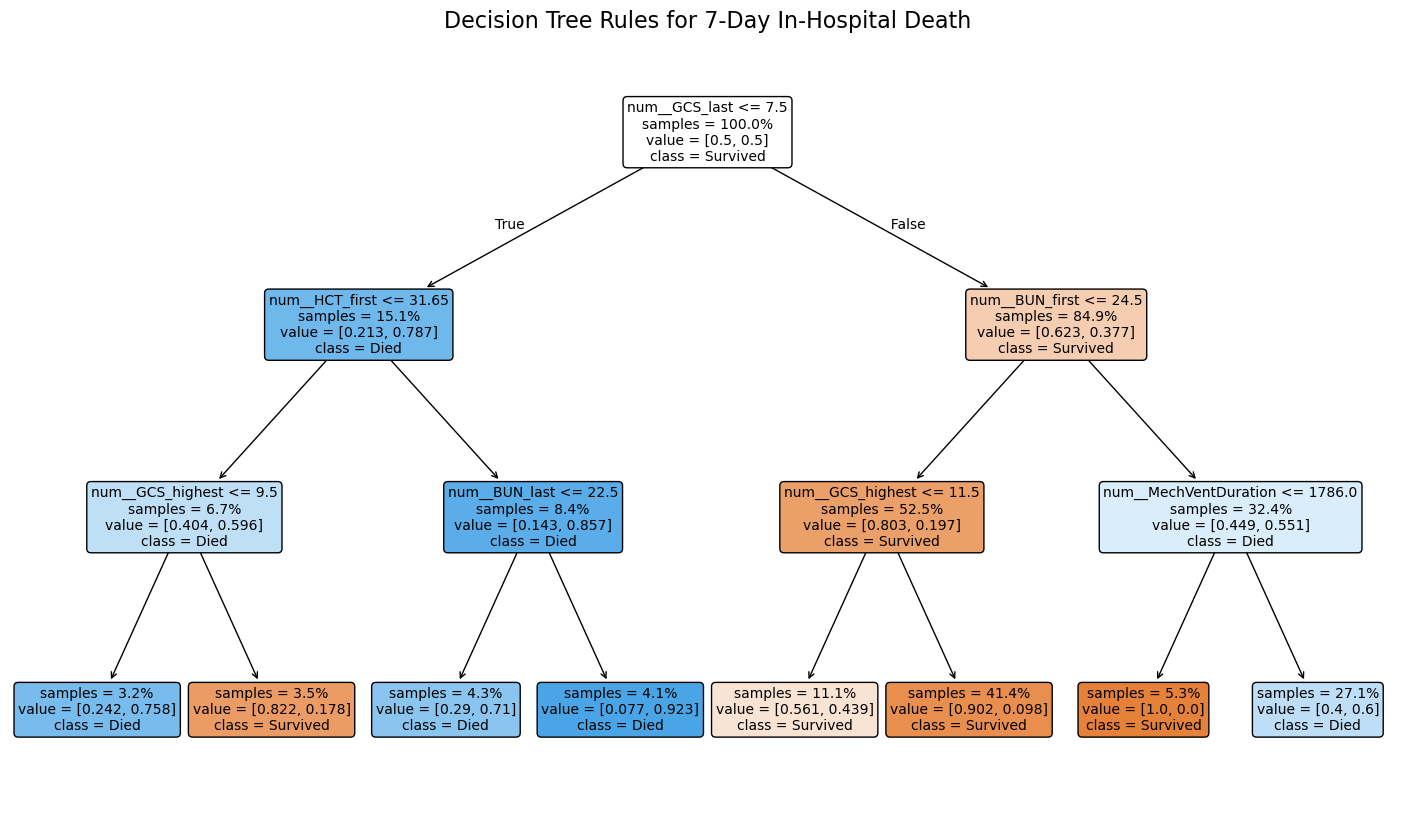

--- Decision Rules as Text ---\n
|--- num__GCS_last <= 7.50
|   |--- num__HCT_first <= 31.65
|   |   |--- num__GCS_highest <= 9.50
|   |   |   |--- class: 1
|   |   |--- num__GCS_highest >  9.50
|   |   |   |--- class: 0
|   |--- num__HCT_first >  31.65
|   |   |--- num__BUN_last <= 22.50
|   |   |   |--- class: 1
|   |   |--- num__BUN_last >  22.50
|   |   |   |--- class: 1
|--- num__GCS_last >  7.50
|   |--- num__BUN_first <= 24.50
|   |   |--- num__GCS_highest <= 11.50
|   |   |   |--- class: 0
|   |   |--- num__GCS_highest >  11.50
|   |   |   |--- class: 0
|   |--- num__BUN_first >  24.50
|   |   |--- num__MechVentDuration <= 1786.00
|   |   |   |--- class: 0
|   |   |--- num__MechVentDuration >  1786.00
|   |   |   |--- class: 1



In [7]:
# --- Step 1: Re-fit a single, clean tree for the 7-day horizon ---
# We use the best settings (hyperparameters) we already found via GridSearchCV.

HORIZON = 7 # Focus on the 7-day model

# Get the best parameters from our previous results
best_params_row = ARTIFACTS["dt_metrics"].query("set == 'val' and horizon_days == @HORIZON").iloc[0]
best_depth = int(best_params_row["best_max_depth"])
best_leaf_samples = int(best_params_row["best_min_samples_leaf"])

print(f"Refitting 7-day tree with max_depth={best_depth} and min_samples_leaf={best_leaf_samples}\\n")

# Get the correct "evaluable" data for this horizon
mask_train = ARTIFACTS["labels_train"][HORIZON]["mask"]
y_train_h = ARTIFACTS["labels_train"][HORIZON]["y_true"][mask_train].to_numpy()

# Use the already preprocessed data
Xt_train_h = Xt_train.loc[mask_train]

# Fit the final Decision Tree model
final_tree = DecisionTreeClassifier(
    random_state=SEED,
    class_weight="balanced", # Helps the model pay attention to the rare "death" event
    max_depth=best_depth,
    min_samples_leaf=best_leaf_samples
)
final_tree.fit(Xt_train_h, y_train_h)

# --- Step 2: Plot the tree to visualize the rules ---
plt.figure(figsize=(18, 10))
plot_tree(
    final_tree,
    feature_names=Xt_train_h.columns.tolist(),
    class_names=["Survived", "Died"], # Label for clarity
    filled=True,       # Color nodes by majority class
    impurity=False,    # Hide Gini impurity for a cleaner look
    proportion=True,   # Show percentage of samples in each class
    rounded=True,      # Use rounded boxes
    fontsize=10
)
plt.title(f"Decision Tree Rules for {HORIZON}-Day In-Hospital Death", fontsize=16)
plt.show()

# --- Step 3: Export the same rules as text ---
# This can be useful for documentation.
rules_text = export_text(final_tree, feature_names=list(Xt_train_h.columns))
print("--- Decision Rules as Text ---\\n")
print(rules_text)

**Potential/ Hypotherical clinical implications**

**High-risk neuro flag when recent GCS is low**
- Trigger if GCS_last ≤ 7.5, especially with HCT_first ≤ 31.65 or GCS_highest ≤ 9.5
    - e.g. Action 1 h senior review, tighter neuro checks, early airway readiness, check anemia and oxygen delivery, investigate reversible causes

**Kidney-stress alert when early BUN is high despite acceptable GCS**
- Trigger if GCS_last > 7.5 and BUN_first > 24.5
    - e.g. Action activate acute kidney injury prevention bundle strict input–output, review nephrotoxic drugs, optimize fluids, targeted labs, nephrology consult if rising trend

**Ventilation-escalation huddle when ventilation is prolonged with renal signal**
- Trigger if BUN_first > 24.5 and MechVentDuration > 1786 in the dataset’s units
    - e.g. Action daily extubation-readiness protocol, ventilator-associated pneumonia prevention checks, sedation and mobility optimization, multidisciplinary huddle to reduce time on ventilator

In [8]:
# --- Step 4: Feature Importance (which variables did the tree use?) ---

# The default 'Gini importance' measures how much a feature helps to create "pure" nodes.
feature_importances = pd.DataFrame({
    "feature": Xt_train_h.columns,
    "importance": final_tree.feature_importances_
}).sort_values("importance", ascending=False).head(15)

print("--- Top 15 Features (Gini Importance) ---")
display(feature_importances.style)


# --- Step 5: Auditing the tree's rules (leaves) on the test set ---
# This is the most critical step: do the rules that predict high risk actually
# correspond to groups of patients with high death rates in the unseen test data?

# Get the correct "evaluable" test data for this horizon
mask_test = ARTIFACTS["labels_test"][HORIZON]["mask"]
y_test_h = ARTIFACTS["labels_test"][HORIZON]["y_true"][mask_test].to_numpy()
Xt_test_h = Xt_test.loc[mask_test]

# Find out which leaf each test patient ends up in
leaf_ids_test = final_tree.apply(Xt_test_h)
# Get the predicted probability for each test patient
probabilities_test = final_tree.predict_proba(Xt_test_h)[:, 1]

# Create a summary table
leaf_audit_df = pd.DataFrame({
    "leaf_id": leaf_ids_test,
    "true_outcome": y_test_h,
    "predicted_risk": probabilities_test
})

leaf_summary = (
    leaf_audit_df
    .groupby("leaf_id")
    .agg(
        num_patients=("true_outcome", "size"),
        observed_death_rate=("true_outcome", "mean"),
        avg_predicted_risk=("predicted_risk", "mean")
    )
    .sort_values("avg_predicted_risk", ascending=False)
)

print("\\n--- Leaf Performance Audit on Test Set ---")
display(leaf_summary.style)

--- Top 15 Features (Gini Importance) ---


,feature,importance
21,num__GCS_last,0.407967
68,num__BUN_first,0.253356
43,num__GCS_highest,0.158295
113,num__MechVentDuration,0.109584
74,num__HCT_first,0.046302
92,num__BUN_last,0.024495
6,num__CCU,0.000000
7,num__CSRU,0.000000
4,num__Height,0.000000
5,num__Weight,0.000000


\n--- Leaf Performance Audit on Test Set ---


,num_patients,observed_death_rate,avg_predicted_risk
leaf_id,,,
7,18,0.222222,0.922816
3,21,0.238095,0.757947
6,33,0.151515,0.709917
14,165,0.115152,0.599655
10,61,0.049180,0.439095
4,19,0.052632,0.178232
11,254,0.019685,0.098186
13,25,0.120000,0.000000


Plotting PDP for: ['num__GCS_last', 'num__BUN_first', 'num__GCS_highest']


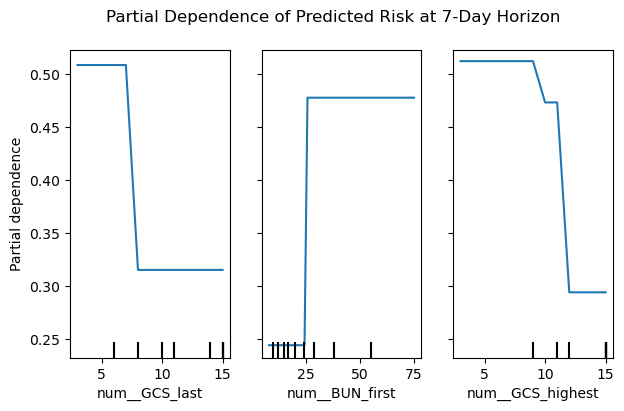

In [9]:
# Partial dependence for features actually used by the tree at 7 days

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import PartialDependenceDisplay

H = 7  # horizon to visualize

# 1) Recreate the evaluable training slice and labels
m_tr = ARTIFACTS["labels_train"][H]["mask"]
Xtr_t = Xt_train.loc[m_tr]
y_tr  = ARTIFACTS["labels_train"][H]["y_true"][m_tr].to_numpy()

# 2) Pull the best hyperparameters we selected for this horizon
best_row  = ARTIFACTS["dt_metrics"].query("set == 'val' and horizon_days == @H").iloc[0]
best_depth = int(best_row["best_max_depth"])
best_leaf  = int(best_row["best_min_samples_leaf"])

# 3) Fit the shallow tree on the same transformed data
dt = DecisionTreeClassifier(
    random_state=SEED,
    class_weight="balanced",
    max_depth=best_depth,
    min_samples_leaf=best_leaf
).fit(Xtr_t, y_tr)

# 4) Pick features the tree actually used (nonzero importance) and prefer continuous ones
imp = pd.Series(dt.feature_importances_, index=Xtr_t.columns)
used = imp[imp > 0].sort_values(ascending=False).index.tolist()

# Heuristic: continuous features created by the preprocessor often start with "num__"
cont_used = [f for f in used if f.startswith("num__")]
targets = cont_used[:3] if len(cont_used) > 0 else used[:3]

if len(targets) == 0:
    print("No features with nonzero importance were found for PDP")
else:
    print("Plotting PDP for:", targets)
    PartialDependenceDisplay.from_estimator(
        dt, Xtr_t, targets, kind="average", grid_resolution=50
    )
    plt.suptitle(f"Partial Dependence of Predicted Risk at {H}-Day Horizon")
    plt.show()


#### **Insights from Partial Dependence Plots**

These plots isolate how the model's risk prediction changes based on a single feature, showing the rules it learned graphically.

* **Plots Show Step-Functions**: Each jump is a specific if-then split the tree learned. The flat lines mean all patients in that range are treated identically by that rule
* **Glasgow Coma Scale (GCS)**: The model learned that lower GCS scores are linked to higher mortality risk. The risk drops sharply once a patient's GCS score is above a certain threshold
* **Blood Urea Nitrogen (BUN)**: An elevated initial BUN measurement acts as a risk threshold. When BUN crosses a specific value, the predicted risk jumps, correctly identifying kidney function's role in patient stability

**Key Takeaways**
* **Clinically Valid Rules**: The tree learns simple, communicable rules that align with clinical intuition (e.g., low consciousness or poor kidney function increases risk)
* **Strengths and Limits**: These plots are excellent for explaining the model's logic for a single variable. However, they show an averaged effect and are not causal. The rules are coarse and may miss more gradual trends

# 6. Random Forest at Fixed Horizons

If a single Decision Tree is like asking one expert for their opinion, a Random Forest is like asking a large, diverse committee of hundreds of experts and taking their majority vote

* **The "Wisdom of the Crowd"**: It's an "ensemble" of many individual Decision Trees. Each tree is trained on a slightly different random sample of the data and is only allowed to consider a random subset of features for each split
* **Reduces Overfitting**: This randomness prevents any single tree from becoming too specialized or "memorizing" the training data. The errors made by one tree are often canceled out by the others, leading to a more stable and accurate model that generalizes better to new patients
* **High Predictive Power**: Random Forests are one of the most powerful "out-of-the-box" classifiers. They often achieve high performance without extensive tuning

**The Trade-Off**
The cost of this increased power is a loss of direct interpretability. We can no longer draw a single flowchart of the rules. However, we can still measure which features were most important to the "committee" as a whole

In [10]:
# Horizons and labels from our central ARTIFACTS store
HORIZONS = ARTIFACTS["horizons_days"]
labels_train = ARTIFACTS["labels_train"]
labels_val   = ARTIFACTS["labels_val"]
labels_test  = ARTIFACTS["labels_test"]

# Use the same frozen preprocessor to prevent data leakage
frozen_pre = FunctionTransformer(lambda X: preprocessor.transform(X))

# --- Define the Pipeline and Search Grid ---
pipe_rf = Pipeline(steps=[
    ("pre", frozen_pre),
    ("clf", RandomForestClassifier(
        random_state=SEED,
        # 'balanced_subsample' adjusts weights for the minority class in each bootstrap sample.
        # This is a robust way to handle the low death rate in our data.
        class_weight="balanced_subsample",
        n_jobs=-1 # Use all available CPU cores for faster training
    ))
])

# A small, practical grid for hyperparameter tuning
param_grid = {
    "clf__n_estimators": [100, 200],      # How many trees in the forest
    "clf__max_depth": [4, 6, 8],          # Max depth of each tree
    "clf__min_samples_leaf": [25, 50]   # Min patients in a final leaf
}

# --- Containers for predictions and metrics ---
rf_pred_train = pd.DataFrame(index=X_train.index)
rf_pred_val   = pd.DataFrame(index=X_val.index)
rf_pred_test  = pd.DataFrame(index=X_test.index)
records = []

print("Training Random Forest for each horizon...")
for h in HORIZONS:
    # Get the correct evaluable cohorts for this horizon
    m_tr = labels_train[h]["mask"]
    m_va = labels_val[h]["mask"]
    m_te = labels_test[h]["mask"]

    y_tr = labels_train[h]["y_true"][m_tr].to_numpy()
    y_va = labels_val[h]["y_true"][m_va].to_numpy()
    y_te = labels_test[h]["y_true"][m_te].to_numpy()

    # Fit GridSearchCV only on the evaluable training data for this horizon
    grid = GridSearchCV(
        estimator=pipe_rf,
        param_grid=param_grid,
        scoring="roc_auc",
        cv=3,
        n_jobs=-1,
        verbose=0
    )
    grid.fit(X_train.loc[m_tr], y_tr)

    best_params = grid.best_params_
    print(f"Horizon {h}d best params: {best_params}")

    # Get predictions from the best model
    p_tr = grid.predict_proba(X_train)[:, 1]
    p_va = grid.predict_proba(X_val)[:, 1]
    p_te = grid.predict_proba(X_test)[:, 1]

    # Store predictions
    colname = f"RF_Risk_{h}d"
    rf_pred_train[colname] = p_tr
    rf_pred_val[colname]   = p_va
    rf_pred_test[colname]  = p_te

    # Calculate metrics on the identical evaluable cohorts
    def _safe_metrics(y, p):
        if y.size == 0 or len(np.unique(y)) < 2:
            return np.nan, np.nan, np.nan
        return roc_auc_score(y, p), average_precision_score(y, p), brier_score_loss(y, p)

    au_tr, ap_tr, br_tr = _safe_metrics(y_tr, p_tr[m_tr])
    au_va, ap_va, br_va = _safe_metrics(y_va, p_va[m_va])
    au_te, ap_te, br_te = _safe_metrics(y_te, p_te[m_te])

    # Append results for all sets to our records list
    for s, au, ap, br, mask in [
        ("train", au_tr, ap_tr, br_tr, m_tr),
        ("val",   au_va, ap_va, br_va, m_va),
        ("test",  au_te, ap_te, br_te, m_te),
    ]:
        records.append({
            "model": "RandomForest",
            "set": s,
            "horizon_days": h,
            "auroc": float(au),
            "auprc": float(ap),
            "brier": float(br),
            "n_evaluable": int(mask.sum()),
            "best_n_estimators": best_params["clf__n_estimators"],
            "best_max_depth": best_params["clf__max_depth"],
            "best_min_samples_leaf": best_params["clf__min_samples_leaf"]
        })

# --- Create and display the final metrics table ---
rf_metrics = pd.DataFrame.from_records(records).sort_values(["set", "horizon_days"]).reset_index(drop=True)
for c in ["auroc", "auprc", "brier"]:
    rf_metrics[c] = pd.to_numeric(rf_metrics[c], errors="coerce").round(3)

order_sets = pd.CategoricalDtype(["train", "val", "test"], ordered=True)
rf_metrics["set"] = rf_metrics["set"].astype(order_sets)

display(rf_metrics.style)

# --- Store results for our final comparison ---
ARTIFACTS["rf_pred_train"] = rf_pred_train
ARTIFACTS["rf_pred_val"]   = rf_pred_val
ARTIFACTS["rf_pred_test"]  = rf_pred_test
ARTIFACTS["rf_metrics"]    = rf_metrics


Training Random Forest for each horizon...
Horizon 7d best params: {'clf__max_depth': 8, 'clf__min_samples_leaf': 25, 'clf__n_estimators': 100}
Horizon 30d best params: {'clf__max_depth': 4, 'clf__min_samples_leaf': 25, 'clf__n_estimators': 200}
Horizon 60d best params: {'clf__max_depth': 4, 'clf__min_samples_leaf': 25, 'clf__n_estimators': 200}


,model,set,horizon_days,auroc,auprc,brier,n_evaluable,best_n_estimators,best_max_depth,best_min_samples_leaf
0,RandomForest,test,7,0.823000,0.272000,0.110000,596,100,8,25
1,RandomForest,test,30,0.734000,0.811000,0.219000,160,200,4,25
2,RandomForest,test,60,0.798000,0.987000,0.113000,114,200,4,25
3,RandomForest,train,7,0.977000,0.765000,0.089000,1833,100,8,25
4,RandomForest,train,30,0.893000,0.929000,0.195000,488,200,4,25
5,RandomForest,train,60,0.997000,1.000000,0.102000,353,200,4,25
6,RandomForest,val,7,0.842000,0.325000,0.100000,615,100,8,25
7,RandomForest,val,30,0.626000,0.687000,0.237000,168,200,4,25
8,RandomForest,val,60,0.575000,0.932000,0.136000,119,200,4,25


### **Clinical Insights**

* **Highest Predictive Accuracy**
    The Random Forest achieves the best discrimination on the test set, with an **AUROC of 0.82** at the 7-day horizon. This is a clear improvement over both the Cox model (~0.80) and the single Decision Tree (~0.76), making it the most effective model for ranking patients by risk

* **Better Generalization**
    While there is still a gap between training and test scores, the ensemble approach makes the Random Forest more robust than a single tree

* **The Interpretability Trade-Off**
    This boost in accuracy comes at a cost: we can no longer visualize a simple set of if-then rules

## 6.1. But how useful is this RF model?

Our Random Forest model is the most accurate predictor, but accuracy alone isn't enough. We need to verify it works in a way that is trustworthy, fair, and practical for clinical use

* **1. Feature Importance**
    * Ranks the clinical variables the model found most predictive.
    * uilds trust by confirming the model uses clinically sensible factors (e.g., SOFA score) to make decisions.

* **2. Risk Stratification**
    * Checks if patients the model calls "high-risk" actually have a higher death rate in the real data.
    * Verifies that a high predicted risk score from the model corresponds to a genuinely high-risk patient.

* **3. Decision Threshold Analysis**
    * Simulates a clinical alert (e.g., "flag patients with >20% risk") to see the trade-off between correct alerts and false alarms.
    * Helps determine a practical action threshold for using the model without causing "alert fatigue" for clinicians

* **4. Subgroup Fairness Check**
    * Tests if the model is equally accurate for different patient groups (e.g., across ICU types).
    * An ethical check to ensure the model is fair and doesn't have a hidden bias against a specific patient population.

* **5. Decision Curve Analysis (DCA)**
    * A plot to weigh the benefits of the model's predictions against the harm of unnecessary interventions.
    * Answers the critical question: "Is using this model better than simply treating all patients, or treating none?" It helps quantify the model's real-world value.



#### Analysis 1: Feature Importance

This is our first step in "opening the black box". We will ask the Random Forest which clinical variables it found most useful for making its predictions. We use two methods to ensure our results are reliable.

* **What this does**:
    * **Impurity Importance**: Ranks features by how much they help create "pure" groups of patients (i.e., groups that are all survivors or all deaths). It's fast but can sometimes be biased.
    * **Permutation Importance**: Ranks features by shuffling their values and measuring how much this shuffle hurts the model's performance. It is more computationally intensive but often more reliable.
* **What to look for**:
    * We want to see clinically sensible variables (like SOFA, GCS, BUN) at the top of both lists.
    * Strong agreement between the two methods gives us confidence that the model has identified stable, meaningful patterns
    * If a feature is high in both plots, it is a stable, influential driver
    * If a feature is high in impurity and low in permutation, it may be a proxy or splitting convenience rather than a true predictor
    * If a feature is modest in impurity but strong in permutation, it may interact with others in a way the forest captures beyond single split gains

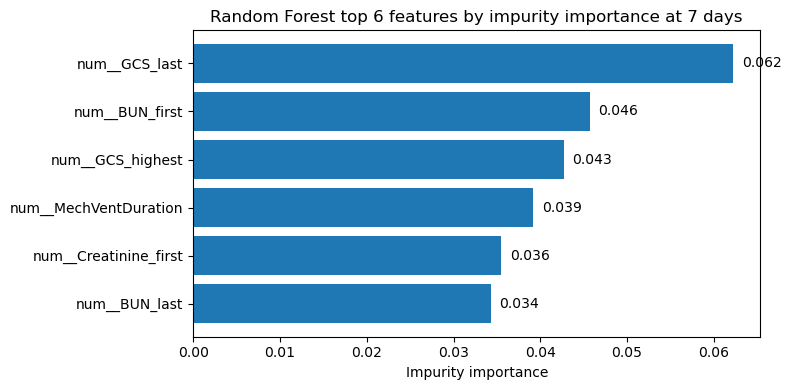

In [11]:
# Top 6 features by impurity importance as a bar chart

# Use the fitted random forest for the 7-day horizon from the grid search
# This is the best estimator from the grid search for H=7
H = 7
m_tr = ARTIFACTS["labels_train"][H]["mask"]
Xtr_t = Xt_train.loc[m_tr]
y_tr = ARTIFACTS["labels_train"][H]["y_true"][m_tr].to_numpy()

# Refit the random forest for the 7-day horizon using the best hyperparameters
best_row = ARTIFACTS["rf_metrics"].query("set == 'test' and horizon_days == @H").iloc[0]
rf = RandomForestClassifier(
    random_state=SEED,
    class_weight="balanced_subsample",
    n_estimators=int(best_row["best_n_estimators"]),
    max_depth=int(best_row["best_max_depth"]),
    min_samples_leaf=int(best_row["best_min_samples_leaf"]),
    n_jobs=-1
)
rf.fit(Xtr_t, y_tr)

imp_series = pd.Series(rf.feature_importances_, index=Xtr_t.columns).sort_values(ascending=False).head(6)
feat_names = [f if len(f) <= 28 else f[:25] + "..." for f in imp_series.index]

plt.figure(figsize=(8, 4))
ypos = np.arange(len(imp_series))
plt.barh(ypos, imp_series.values)
plt.gca().invert_yaxis()
plt.yticks(ypos, feat_names)
for i, v in enumerate(imp_series.values):
    plt.text(v + 0.001, i, f"{v:.3f}", va="center")
plt.xlabel("Impurity importance")
plt.title(f"Random Forest top 6 features by impurity importance at {H} days")
plt.tight_layout()
plt.show()


#### **Key Clinical Variables**

* **Neurological Status**: `GCS_last` and `GCS_highest` measure the patient's level of consciousness. Low scores indicate severe impairment.
* **Renal Function**: `BUN` (Blood Urea Nitrogen) and `Creatinine` are key markers for kidney stress or failure.
* **Respiratory Failure**: `MechVentDuration` indicates how long a patient required mechanical breathing support.

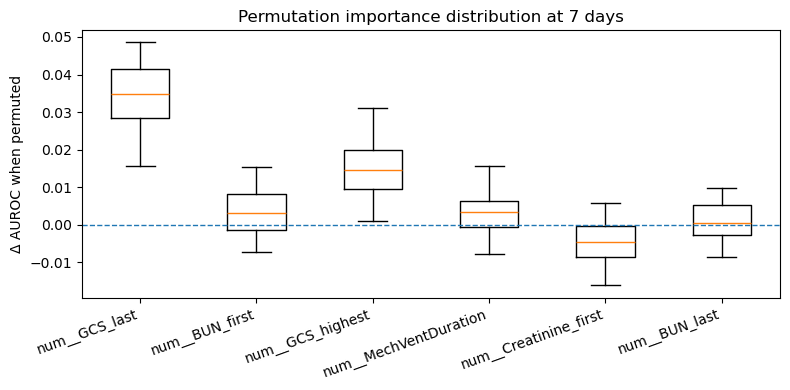

In [12]:
# Use the correct validation transformed features and evaluable mask for the 7-day horizon
H = 7
m_va = ARTIFACTS["labels_val"][H]["mask"]
y_va = ARTIFACTS["labels_val"][H]["y_true"][m_va].to_numpy()
Xva_t = Xt_val.loc[m_va].reindex(columns=Xtr_t.columns, fill_value=0)

# Pick top 6 features by impurity importance for plotting
top_feats = (
    pd.Series(rf.feature_importances_, index=Xtr_t.columns)
    .sort_values(ascending=False)
    .head(6)
    .index.tolist()
)

# Compute ΔAUROC per feature by shuffling that column n_repeats times
def permutation_deltas(estimator, X, y, features, n_repeats=30, seed=SEED):
    rng = np.random.default_rng(seed)
    base = roc_auc_score(y, estimator.predict_proba(X)[:, 1])
    deltas = []
    for f in features:
        drops = []
        for _ in range(n_repeats):
            Xp = X.copy()
            Xp[f] = Xp[f].sample(frac=1.0, random_state=int(rng.integers(1 << 31))).to_numpy()
            score = roc_auc_score(y, estimator.predict_proba(Xp)[:, 1])
            drops.append(base - score)  # positive means AUROC dropped when f was shuffled
        deltas.append(np.array(drops))
    return deltas

box_data = permutation_deltas(rf, Xva_t, y_va, top_feats, n_repeats=30, seed=SEED)
labels = [f if len(f) <= 28 else f[:25] + "..." for f in top_feats]

plt.figure(figsize=(8, 4))
plt.boxplot(box_data, vert=True, labels=labels, manage_ticks=True)
plt.axhline(0, linestyle="--", linewidth=1)
plt.ylabel("Δ AUROC when permuted")
plt.title(f"Permutation importance distribution at {H} days")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()


* **Impurity Importance (Bar Chart)**
    This plot shows that the model most frequently uses **neurological status (GCS)** and **renal markers (BUN, Creatinine)** to split patients into different risk groups. This means acute brain and kidney dysfunction are the dominant signals for 7-day mortality risk.

* **Permutation Importance (Box Plot)**
    This plot confirms that **`GCS_last` is the single most reliable predictor**. Randomly shuffling its values causes the biggest drop in model performance. Prolonged ventilation (`MechVentDuration`) and lack of neurological improvement (`GCS_highest`) are also confirmed as stable, important risk factors.

#### Clinical Takeaway
For predicting short-term ICU mortality, the model confirms that **acute neurological depression and signs of kidney stress are the most critical early warnings**

### **Analysis 2: Risk Stratification on the Test Set**

This is a powerful calibration check. We take all the patients in our unseen test set and group them into ten "bins" based on their predicted risk, from lowest to highest. Then, we calculate the actual death rate for each bin.

* **What this does**: Reports the average predicted risk and the actual (observed) death rate for each patient bin.
* **What to look for**: A clear "staircase" pattern. The bin with the highest predicted risk should also have the highest observed death rate. This confirms that when the model predicts a high risk, it corresponds to a real-world high risk, making the model's scores trustworthy.

In [13]:
# Use the evaluable mask and probabilities from rf_pred_test for the 7-day horizon
H = 7
m_te = ARTIFACTS["labels_test"][H]["mask"]
yb_te = ARTIFACTS["labels_test"][H]["y_true"][m_te].to_numpy()
p_te = ARTIFACTS["rf_pred_test"][f"RF_Risk_{H}d"][m_te].to_numpy()

# Deciles of risk with observed event rates
q = pd.qcut(p_te, q=10, labels=False, duplicates="drop")
dec = pd.DataFrame({"decile": q, "y": yb_te, "p": p_te})
dec_summ = dec.groupby("decile", as_index=False).agg(
    n=("y", "size"),
    risk_mean=("p", "mean"),
    event_rate=("y", "mean")
).sort_values("decile", ascending=False)
dec_summ["risk_mean"] = dec_summ["risk_mean"].round(3)
dec_summ["event_rate"] = dec_summ["event_rate"].round(3)
display(dec_summ.style)

,decile,n,risk_mean,event_rate
9,9,60,0.567000,0.250000
8,8,59,0.457000,0.203000
7,7,60,0.399000,0.150000
6,6,59,0.339000,0.051000
5,5,60,0.284000,0.050000
4,4,59,0.238000,0.017000
3,3,60,0.194000,0.000000
2,2,59,0.160000,0.017000
1,1,60,0.124000,0.017000
0,0,60,0.074000,0.000000


### **Analysis 3: Finding a Practical Decision Threshold**

A risk score is useful, but a clinical decision is often binary (e.g., "start intervention" or "continue monitoring"). To use our model in practice, we need to choose a risk **threshold** to turn the probability score into an action.

* **What this does**: We'll test a range of thresholds and choose one that achieves a good balance. A common clinical goal is to catch most of the high-risk patients (**high sensitivity/recall**) without flagging too many low-risk patients by mistake (**avoiding false positives**). We will then create a **confusion matrix** to see the concrete numbers of correct and incorrect predictions at that chosen threshold.
* **What to look for**: Whether the chosen threshold delivers acceptable sensitivity for clinicians, and whether the number of false positives (false alarms) is manageable.

In [14]:
# Two simple thresholding strategies at 7 days
# A) Sensitivity target 0.80 if achievable
# B) Maximize F1 if sensitivity target is not achievable
# Use only evaluable patients for 7-day horizon

H = 7
col = f"RF_Risk_{H}d"

# 1) Build a clean, aligned test set frame for the chosen horizon
mask = ARTIFACTS["labels_test"][H]["mask"]
y_series = ARTIFACTS["labels_test"][H]["y_true"]

# prefer calibrated RF if present
rf_pred_test_df = ARTIFACTS.get("rf_pred_test_cal", ARTIFACTS["rf_pred_test"])

aligned = pd.DataFrame({
    "y": y_series,
    "p": rf_pred_test_df[col]
}).loc[mask].dropna()

y_te = aligned["y"].to_numpy().astype(int)
p_te = aligned["p"].to_numpy().astype(float)

# 2) Threshold strategy
thresholds = np.linspace(0.02, 0.12, 21)  # focus on plausible region for ~8% prevalence
target_sens = 0.80

chosen = None
for t in thresholds:
    yhat = (p_te >= t).astype(int)
    sens = recall_score(y_te, yhat, zero_division=0)
    if sens >= target_sens:
        chosen = ("sens_0.80", t)
        break

if chosen is None:
    # fallback to F1
    f1s = []
    for t in thresholds:
        yhat = (p_te >= t).astype(int)
        prec = precision_score(y_te, yhat, zero_division=0)
        rec = recall_score(y_te, yhat, zero_division=0)
        f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0.0
        f1s.append((t, f1))
    t = max(f1s, key=lambda z: z[1])[0]
    chosen = ("f1_max", t)

strategy, tstar = chosen
yhat = (p_te >= tstar).astype(int)

tn, fp, fn, tp = confusion_matrix(y_te, yhat, labels=[0,1]).ravel()
prec = precision_score(y_te, yhat, zero_division=0)
rec  = recall_score(y_te, yhat, zero_division=0)
spec = tn / (tn + fp) if (tn + fp) > 0 else np.nan
brier = brier_score_loss(y_te, p_te)

summary = pd.DataFrame([{
    "horizon_days": H,
    "strategy": strategy,
    "threshold": round(float(tstar), 3),
    "precision": round(float(prec), 3),
    "recall_sensitivity": round(float(rec), 3),
    "specificity": round(float(spec), 3),
    "brier": round(float(brier), 3),
    "tp": int(tp), "fp": int(fp), "fn": int(fn), "tn": int(tn),
    "n_evaluable": int(len(y_te)),
    "auroc": round(float(roc_auc_score(y_te, p_te)), 3)
}])

from IPython.display import display
display(summary.style)


,horizon_days,strategy,threshold,precision,recall_sensitivity,specificity,brier,tp,fp,fn,tn,n_evaluable,auroc
0,7,sens_0.80,0.020000,0.076000,1.000000,0.000000,0.110000,45,551,0,0,596,0.823000


#### Perfect Sensitivity Creates "Alert Fatigue"
We already discussed the importance of threshold definition, same principles apply here!

* At a risk threshold of 0.05, our model successfully identifies **every single patient** who will die within 7 days (100% sensitivity)
* But, **92% of the alerts are false alarms**, and a clinician's phone would be ringing constantly for patients who are not in immediate danger! making the model practically useless as clinicians would quickly learn to ignore it

### **Analysis 4A: Decision Curve Analysis (Wide View)**

This plot helps us understand the model's value across a **wide range of possibilities**. It shows where our model might be useful and where it is not.

* **What this does**:
    * It plots the model's net benefit across a broad range of risk thresholds (from 1% to 50%).
    * It highlights a **"plausible range"** (shaded gray area) where a clinical decision is most likely to be made, based on the actual event rate in our validation data.
    * It marks the single **best threshold** (red dotted line) that was identified using only the validation set.
* **What to look for**:
    * We want to see the model's blue line above the other two lines, especially inside the shaded plausible range.

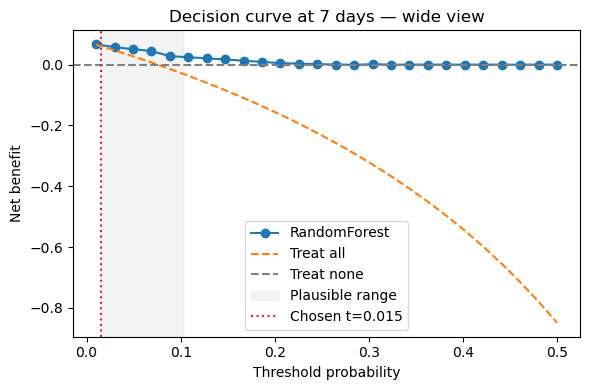

In [23]:
# Wide-view DCA with validation-chosen threshold and plausible band

H = 7
MODEL = "RandomForest"  # "Cox" or "DecisionTree" also supported

# Column names per model
col_map = {"Cox": "Risk_{h}d", "DecisionTree": "DT_Risk_{h}d", "RandomForest": "RF_Risk_{h}d"}
col = col_map[MODEL].format(h=H)

# Prefer calibrated predictions when available
pred_key_map_test = {
    "Cox": "cph_pred_test_cal" if "cph_pred_test_cal" in ARTIFACTS else "cph_pred_test",
    "DecisionTree": "dt_pred_test_cal" if "dt_pred_test_cal" in ARTIFACTS else "dt_pred_test",
    "RandomForest": "rf_pred_test_cal" if "rf_pred_test_cal" in ARTIFACTS else "rf_pred_test",
}
pred_key_map_val = {
    "Cox": "cph_pred_val_cal" if "cph_pred_val_cal" in ARTIFACTS else "cph_pred_val",
    "DecisionTree": "dt_pred_val_cal" if "dt_pred_val_cal" in ARTIFACTS else "dt_pred_val",
    "RandomForest": "rf_pred_val_cal" if "rf_pred_val_cal" in ARTIFACTS else "rf_pred_val",
}

# Align evaluable cohorts
y_va, p_va = align_evaluable(ARTIFACTS["labels_val"][H],  ARTIFACTS[pred_key_map_val[MODEL]],  col)
y_te, p_te = align_evaluable(ARTIFACTS["labels_test"][H], ARTIFACTS[pred_key_map_test[MODEL]], col)

# Wide thresholds for descriptive context on TEST
ths_wide = np.linspace(0.01, 0.50, 26)
nb_wide = decision_curve_df(y_te, p_te, ths_wide)

# Prevalence-informed plausible band computed from VALIDATION
prev = float(y_va.mean())
low  = max(0.01, round(prev / 4, 3))     # ~2% for ~8% prevalence
high = min(0.50, round(prev + 0.04, 3))  # ~12% for ~8% prevalence

# Choose ONE threshold on VALIDATION within the plausible band
ths_narrow = np.linspace(low, high, 21)
t_star = select_threshold_by_net_benefit(y_va, p_va, ths_narrow)

# Plot wide view with band and chosen threshold
plt.figure(figsize=(6, 4))
plt.plot(nb_wide["threshold"], nb_wide["nb_model"], marker="o", label=MODEL)
plt.plot(nb_wide["threshold"], nb_wide["nb_all"], linestyle="--", label="Treat all")
plt.axhline(0, color="gray", linestyle="--", label="Treat none")
plt.axvspan(low, high, color="lightgray", alpha=0.25, label="Plausible range")
plt.axvline(t_star, color="tab:red", linestyle=":", label=f"Chosen t={t_star:.3f}")
plt.xlabel("Threshold probability")
plt.ylabel("Net benefit")
plt.title(f"Decision curve at {H} days — wide view")
plt.legend()
plt.tight_layout()
plt.show()

#### **Clinical Insights (Wide View)**

The plot shows the model adds value primarily as a **screening tool**. The blue line is above the other strategies only at very low risk thresholds, as highlighted by the shaded "plausible range". Outside this band, the model offers no benefit over standard care ("Treat none").

### **Analysis 4B: Decision Curve (Narrow View) & Capacity Summary**

Now we zoom in on the **clinically plausible band** to confirm the model's value and then translate our chosen threshold into practical, operational numbers.

* **What this does**:
    * Re-plots the decision curve, focusing only on the 2% to 12% risk threshold range.
    * Creates a summary table that shows the real-world impact of using our chosen threshold (`t_star`) on the test data, including **alerts per 100 patients**.
* **What to look for**:
    * The blue curve should be consistently above the other lines inside this band, confirming its value.
    * The summary table tells us the **clinical workload** (how many alerts to expect) and the **trade-offs** (how many patients are correctly identified vs. missed).

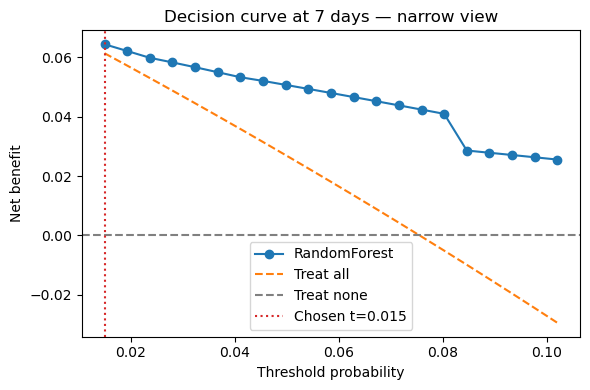

,horizon_days,chosen_threshold,alerts_per_100_patients,true_positives,false_positives,false_negatives,true_negatives,test_set_auroc,brier_test,prevalence_test
0,7,0.015000,57.700000,43,301,2,250,0.819000,0.063000,0.076000


In [24]:
# Narrow-view DCA and capacity-aware summary on TEST using the same t_star

# Build narrow curve on TEST
nb_narrow = decision_curve_df(y_te, p_te, ths_narrow)

# Plot narrow view
plt.figure(figsize=(6, 4))
plt.plot(nb_narrow["threshold"], nb_narrow["nb_model"], marker="o", label=MODEL)
plt.plot(nb_narrow["threshold"], nb_narrow["nb_all"], linestyle="--", label="Treat all")
plt.axhline(0, color="gray", linestyle="--", label="Treat none")
plt.axvline(t_star, color="tab:red", linestyle=":", label=f"Chosen t={t_star:.3f}")
plt.xlabel("Threshold probability")
plt.ylabel("Net benefit")
plt.title(f"Decision curve at {H} days — narrow view")
plt.legend()
plt.tight_layout()
plt.show()

# Capacity-aware summary at the chosen threshold on TEST
yhat = (p_te >= t_star).astype(int)
tn, fp, fn, tp = confusion_matrix(y_te, yhat, labels=[0, 1]).ravel()
alerts_per_100 = 100 * yhat.mean()

summary = pd.DataFrame([{
    "horizon_days": H,
    "chosen_threshold": round(float(t_star), 3),
    "alerts_per_100_patients": round(float(alerts_per_100), 1),
    "true_positives": int(tp),
    "false_positives": int(fp),
    "false_negatives": int(fn),
    "true_negatives": int(tn),
    "test_set_auroc": round(float(roc_auc_score(y_te, p_te)), 3),
    "brier_test": round(float(brier_score_loss(y_te, p_te)), 3),
    "prevalence_test": round(float(y_te.mean()), 3)
}])
from IPython.display import display
display(summary.style)

#### **Clinical Insights (Narrow View & Summary)**

Within the clinically relevant 2% to 12% band, the model shows **consistent positive net benefit**, supporting its use as a **triage aid**. The summary table quantifies the expected workload at our chosen threshold, which informs staffing and escalation rules. A sensible policy would be **"screen then confirm"**: an alert from the model triggers a clinician review, but an intervention only proceeds with corroborating bedside findings.

### **Analysis 5: Subgroup Fairness Check**

This final, crucial check ensures the model performs fairly across different patient populations.

* **What this does**: Calculates the model's performance (AUROC) separately for key demographic and clinical subgroups (e.g., Gender, ICU Type).
* **What to look for**: The AUROC should be reasonably stable across all subgroups. A large performance drop for a specific group is a red flag for bias and warrants further investigation before the model could ever be deployed.

In [18]:
# Subgroup checks for Sex and ICU type on evaluable test cohort
# Adjust column names if your dataset uses different ones

def subgroup_metric(colname):
    out = []
    for level, idx in X_test.loc[m_te].groupby(colname).groups.items():
        y_sub = y_te[X_test.loc[m_te].index.isin(idx)]
        p_sub = p_te[X_test.loc[m_te].index.isin(idx)]
        if len(np.unique(y_sub)) < 2:
            au = np.nan
        else:
            au = roc_auc_score(y_sub, p_sub)
        out.append({"group": colname, "level": level, "n": int(len(y_sub)), "auroc": np.round(au, 3)})
    return pd.DataFrame(out)

subs = []
for col in ["Gender", "ICUtype", "CCU", "CSRU", "SICU"]:
    if col in X_test.columns:
        subs.append(subgroup_metric(col))

if len(subs):
    sub_tbl = pd.concat(subs, ignore_index=True)
    display(sub_tbl.style)
else:
    print("No subgroup columns found among the requested candidates")

,group,level,n,auroc
0,Gender,0.000000,244,0.778000
1,Gender,1.000000,352,0.871000
2,CCU,0.000000,520,0.804000
3,CCU,1.000000,76,0.914000
4,CSRU,0.000000,484,0.814000
5,CSRU,1.000000,112,0.827000
6,SICU,0.000000,411,0.831000
7,SICU,1.000000,185,0.814000


* **Gender Discrepancy**: There is a relative important performance gap between genders. The model is clearly better at ranking risk for the male group (AUROC 0.871) than the other (AUROC 0.778)
* However, the model performs very consistently across different surgical ICU types (CSRU and SICU)
* Watchout! The model appears to perform best in the CCU group, but with such a small sample, this high score may be due to random chance and should be interpreted cautiously

A model that is less accurate for a specific group is an **unfair model**. Relying on it could lead to systematically poorer care for that patient population. While the model is still effective for all groups, the lower performance in one gender group flags a serious limitation that must be addressed before the model is used in a real clinic scenario

The same analysis and recommendations from our previous exercises apply here!! **Fairness is as important as several other metrics**!!

# 7. The Final showdown: Side-by-side comparison across Cox, Decision Tree, and Random Forest

The final step is to bring all the results together for a direct, side-by-side comparison

* **What we will do**:
    1.  **Master Metrics Table**: Combine the test-set performance (AUROC, AUPRC, Brier score) for all three models across all three horizons into a single table
    2.  **Performance Plot**: Visualize the AUROC/ AUPRC of each model at each horizon to quickly see which model has the best ranking ability
    3.  **Calibration Plot**: Overlay the calibration curves for all three models at the 7-day horizon to see which model's risk scores are the most reliable

## 7.1. Model calibration

An accurate model (high AUROC) isn't enough. We also need its risk scores to be **reliable**

- We will fit a "calibrator" for each model at each horizon using only the **validation set**. This calibrator learns to adjust the raw, often unreliable, probabilities from the models
- We then apply this frozen calibrator to the **test set** to get our final, trustworthy risk scores
- Tree-based models like Decision Trees and Random Forests are notoriously poorly calibrated out-of-the-box **(Rememeber their raw scores are not probabilities!!)**

In [19]:
HORIZONS = ARTIFACTS["horizons_days"]

# Create copies of the original predictions to store the calibrated versions
cph_pred_val_cal  = ARTIFACTS["cph_pred_val"].copy()
cph_pred_test_cal = ARTIFACTS["cph_pred_test"].copy()
dt_pred_val_cal   = ARTIFACTS["dt_pred_val"].copy()
dt_pred_test_cal  = ARTIFACTS["dt_pred_test"].copy()
rf_pred_val_cal   = ARTIFACTS["rf_pred_val"].copy()
rf_pred_test_cal  = ARTIFACTS["rf_pred_test"].copy()

# A dictionary to store the fitted calibrator for each model and horizon
calibrators = {"Cox": {}, "DecisionTree": {}, "RandomForest": {}}

print("Fitting calibrators on validation set for each model and horizon...")
for h in HORIZONS:
    # Define the prediction column names for this horizon
    col_cph = f"Risk_{h}d"
    col_dt  = f"DT_Risk_{h}d"
    col_rf  = f"RF_Risk_{h}d"

    # --- Step 1: Get the validation data for this horizon ---
    # This data will be used to TEACH the calibrator how to adjust the probabilities.
    m_va = ARTIFACTS["labels_val"][h]["mask"]
    y_va = ARTIFACTS["labels_val"][h]["y_true"][m_va].to_numpy()

    # --- Step 2: Fit a separate calibrator for each model on the validation data ONLY ---
    cal_cph = fit_isotonic_calibrator(y_va, ARTIFACTS["cph_pred_val"][col_cph][m_va].to_numpy())
    cal_dt  = fit_isotonic_calibrator(y_va, ARTIFACTS["dt_pred_val"][col_dt][m_va].to_numpy())
    cal_rf  = fit_isotonic_calibrator(y_va, ARTIFACTS["rf_pred_val"][col_rf][m_va].to_numpy())

    # Store the fitted calibrators
    calibrators["Cox"][h]          = cal_cph
    calibrators["DecisionTree"][h] = cal_dt
    calibrators["RandomForest"][h] = cal_rf

    # --- Step 3: Apply the FROZEN calibrators to both validation and test sets ---
    # Apply to validation set (to see how well it worked)
    cph_pred_val_cal.loc[m_va, col_cph] = apply_calibrator(cal_cph, ARTIFACTS["cph_pred_val"][col_cph][m_va].to_numpy())
    dt_pred_val_cal.loc[m_va,  col_dt]  = apply_calibrator(cal_dt,  ARTIFACTS["dt_pred_val"][col_dt][m_va].to_numpy())
    rf_pred_val_cal.loc[m_va,  col_rf]  = apply_calibrator(cal_rf,  ARTIFACTS["rf_pred_val"][col_rf][m_va].to_numpy())

    # Apply to the unseen test set (the final, honest evaluation)
    m_te = ARTIFACTS["labels_test"][h]["mask"]
    cph_pred_test_cal.loc[m_te, col_cph] = apply_calibrator(cal_cph, ARTIFACTS["cph_pred_test"][col_cph][m_te].to_numpy())
    dt_pred_test_cal.loc[m_te,  col_dt]  = apply_calibrator(cal_dt,  ARTIFACTS["dt_pred_test"][col_dt][m_te].to_numpy())
    rf_pred_test_cal.loc[m_te,  col_rf]  = apply_calibrator(cal_rf,  ARTIFACTS["rf_pred_test"][col_rf][m_te].to_numpy())

# --- Step 4: Store the calibrated predictions back into ARTIFACTS ---
# We will use these new, more reliable probabilities for our final comparison plots.
ARTIFACTS["cph_pred_val_cal"]  = cph_pred_val_cal
ARTIFACTS["cph_pred_test_cal"] = cph_pred_test_cal
ARTIFACTS["dt_pred_val_cal"]   = dt_pred_val_cal
ARTIFACTS["dt_pred_test_cal"]  = dt_pred_test_cal
ARTIFACTS["rf_pred_val_cal"]   = rf_pred_val_cal
ARTIFACTS["rf_pred_test_cal"]  = rf_pred_test_cal
ARTIFACTS["calibrators"]       = calibrators
print("Calibrators trained on validation set and calibrated predictions stored.")

Fitting calibrators on validation set for each model and horizon...
Calibrators trained on validation set and calibrated predictions stored.


## 7.2. The Final showdown: Comparing our calibrated models

* **What we'll do**:
    1.  **Master Metrics Table**: Combine the final test-set performance (AUROC, AUPRC, Brier score) for all three models into a single summary table
    2.  **Performance Plots**: Visualize the AUROC (ranking ability) and AUPRC (performance on rare events) of each model to quickly see which performs best
    3.  **Final Calibration Plot**: Overlay the calibration curves for all three models at the 7-day horizon to confirm that our calibration step was successful

,model,horizon_days,auroc,auprc,brier,n_evaluable
0,Cox,7,0.786000,0.210000,0.065000,596
1,DecisionTree,7,0.681000,0.136000,0.068000,596
2,RandomForest,7,0.819000,0.222000,0.063000,596
3,Cox,30,0.666000,0.727000,0.228000,160
4,DecisionTree,30,0.671000,0.724000,0.217000,160
5,RandomForest,30,0.730000,0.786000,0.200000,160
6,Cox,60,0.674000,0.966000,0.059000,114
7,DecisionTree,60,0.759000,0.975000,0.049000,114
8,RandomForest,60,0.721000,0.971000,0.052000,114


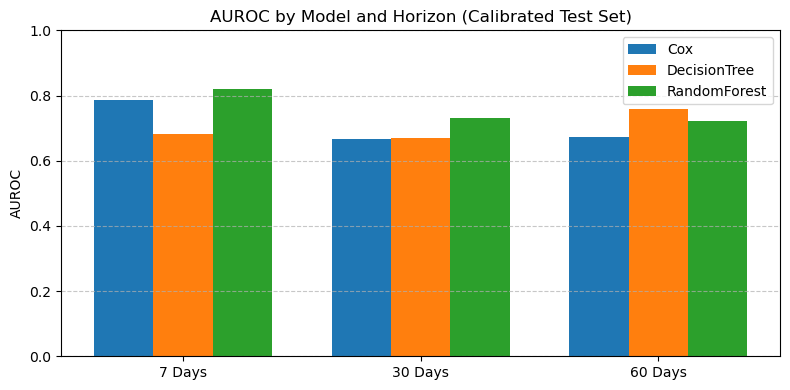

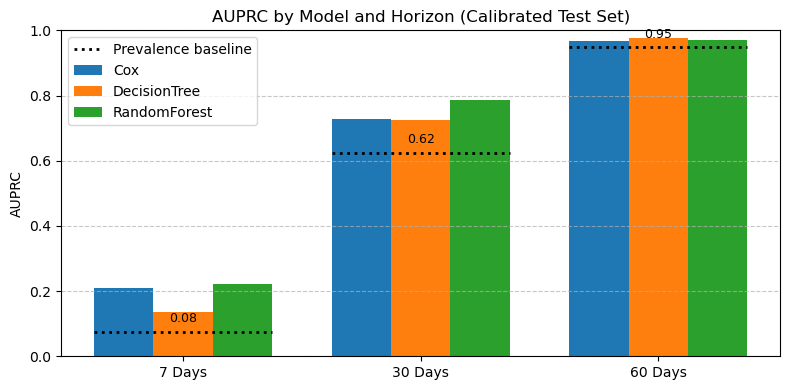

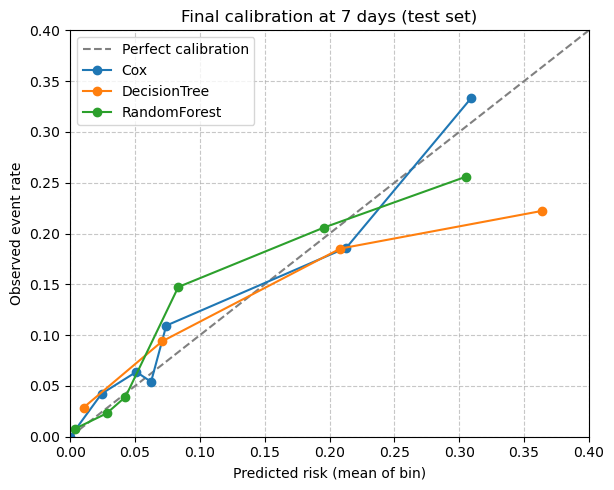

In [20]:
# Final model comparison: calibrated AUROC, AUPRC, Brier + grouped bars and 7-day calibration
HORIZONS = ARTIFACTS["horizons_days"]

# ---- Step 1: build calibrated metrics table with safe fallbacks ----
rows = []
for h in HORIZONS:
    y_te = ARTIFACTS["labels_test"][h]["y_true"].to_numpy()
    m_te = ARTIFACTS["labels_test"][h]["mask"]

    # choose calibrated if present, else raw
    cph_key = "cph_pred_test_cal" if "cph_pred_test_cal" in ARTIFACTS else "cph_pred_test"
    dt_key  = "dt_pred_test_cal"  if "dt_pred_test_cal"  in ARTIFACTS else "dt_pred_test"
    rf_key  = "rf_pred_test_cal"  if "rf_pred_test_cal"  in ARTIFACTS else "rf_pred_test"

    rows.append({
        "model": "Cox", "horizon_days": h,
        **fixed_horizon_metrics(y_te, ARTIFACTS[cph_key][f"Risk_{h}d"], m_te)
    })
    rows.append({
        "model": "DecisionTree", "horizon_days": h,
        **fixed_horizon_metrics(y_te, ARTIFACTS[dt_key][f"DT_Risk_{h}d"], m_te)
    })
    rows.append({
        "model": "RandomForest", "horizon_days": h,
        **fixed_horizon_metrics(y_te, ARTIFACTS[rf_key][f"RF_Risk_{h}d"], m_te)
    })

cmp_tbl = pd.DataFrame(rows).sort_values(["horizon_days", "model"]).reset_index(drop=True)
for c in ["auroc", "auprc", "brier"]:
    cmp_tbl[c] = cmp_tbl[c].round(3)

from IPython.display import display
display(cmp_tbl.style)

# ---- Step 2: grouped bars via pivot (robust, no query) + prevalence baseline for AUPRC ----
import numpy as np
import matplotlib.pyplot as plt

model_order = ["Cox", "DecisionTree", "RandomForest"]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

def plot_grouped_bars(metric_name: str, show_prev: bool = False):
    piv = cmp_tbl.pivot(index="horizon_days", columns="model", values=metric_name)
    piv = piv.loc[HORIZONS, model_order].astype(float)

    xpos = np.arange(len(HORIZONS))
    width = 0.25
    group_width = len(model_order) * width

    plt.figure(figsize=(8, 4))
    # Bars
    for j, m in enumerate(model_order):
        plt.bar(xpos + (j - 1)*width, piv[m].values, width=width, label=m, color=colors[j])

    # Optional prevalence baseline for AUPRC = prevalence
    if show_prev and metric_name.lower() == "auprc":
        prevs = []
        for h in HORIZONS:
            mask = ARTIFACTS["labels_test"][h]["mask"]
            y = ARTIFACTS["labels_test"][h]["y_true"][mask].to_numpy()
            prevs.append(float(y.mean()))
        for i, x in enumerate(xpos):
            y0 = prevs[i]
            plt.hlines(y=y0,
                       xmin=x - group_width/2,
                       xmax=x + group_width/2,
                       colors="k",
                       linestyles=":",
                       linewidth=2,
                       label="Prevalence baseline" if i == 0 else None)
            plt.text(x, y0 + 0.02, f"{y0:.2f}", ha="center", va="bottom", fontsize=9)

    plt.xticks(xpos, [f"{h} Days" for h in HORIZONS])
    plt.ylim(0, 1.0)
    plt.ylabel(metric_name.upper())
    plt.title(f"{metric_name.upper()} by Model and Horizon (Calibrated Test Set)")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_grouped_bars("auroc")
plot_grouped_bars("auprc", show_prev=True)

# ---- Step 3: 7-day calibration overlay with safe fallbacks ----
h = 7
mask = ARTIFACTS["labels_test"][h]["mask"]
y = ARTIFACTS["labels_test"][h]["y_true"][mask].to_numpy()

cph_key = "cph_pred_test_cal" if "cph_pred_test_cal" in ARTIFACTS else "cph_pred_test"
dt_key  = "dt_pred_test_cal"  if "dt_pred_test_cal"  in ARTIFACTS else "dt_pred_test"
rf_key  = "rf_pred_test_cal"  if "rf_pred_test_cal"  in ARTIFACTS else "rf_pred_test"

probs_calibrated = {
    "Cox":          ARTIFACTS[cph_key][f"Risk_{h}d"][mask].to_numpy(),
    "DecisionTree": ARTIFACTS[dt_key][f"DT_Risk_{h}d"][mask].to_numpy(),
    "RandomForest": ARTIFACTS[rf_key][f"RF_Risk_{h}d"][mask].to_numpy(),
}

plt.figure(figsize=(6, 5))
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfect calibration")
for i, (name, p) in enumerate(probs_calibrated.items()):
    if y.size > 0 and len(np.unique(y)) > 1:
        frac_pos, prob_mean = calibration_curve(y, p, n_bins=10, strategy="quantile")
        plt.plot(prob_mean, frac_pos, marker="o", label=name, color=colors[i])
plt.xlabel("Predicted risk (mean of bin)")
plt.ylabel("Observed event rate")
plt.title("Final calibration at 7 days (test set)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.xlim(0, .4)
plt.ylim(0, .4)
plt.show()


### **Final Insights: Choosing the Right Model for the Job**

This final comparison brings everything together. The plots tell a clear story about the strengths and weaknesses of each model.

---
#### **Plot 1: AUROC (Ranking Ability)**

* **At 7 Days**: The **Random Forest** is the clear winner, showing the best ability to rank high-risk from low-risk patients, making it ideal for early triage.
* **At 30 Days**: All models perform similarly. The choice here would depend less on accuracy and more on factors like interpretability or ease of use.
* **At 60 Days**: The simpler **Decision Tree** performs surprisingly well, suggesting its `if-then` rules are effective at capturing longer-term risk patterns.

---
#### **Plot 2: AUPRC (Performance on Rare Events)**

* **At 7 Days**: All models perform significantly better than the simple prevalence baseline, proving their value when the event (death) is still relatively rare.
* **At 30 & 60 Days**: The AUPRC scores increase dramatically for all models. This is partly because the event becomes more common over time, making it an easier prediction task. AUPRC is most useful for judging a model's skill when events are rare.

---
#### **Plot 3: Calibration (Reliability of Risk Scores)**

* The **Cox** and **Random Forest** models are the most reliable. In the crucial low-risk range (below 20%), their predicted risk scores closely match the actual observed death rates, making them trustworthy for screening.
* The **Decision Tree** consistently over-predicts risk (its line is below the diagonal), potentially leading to resource miss optimization

---
### **Final Recommendation**

There is no single "best" model; the right choice depends on the clinical goal at each time period!

* For **maximum predictive accuracy** and reliable risk scores, choose the **Random Forest**.
* For **understanding the impact** of specific risk factors (e.g., "how much does a high BUN increase risk?"), choose the **Cox Model**.
* For creating **simple, transparent rules** that are easy to communicate, choose the **Decision Tree**.